# Task 2:
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.ZBv8C3ZBy5e) with its corresponding description. 

- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures. 


I shall be using the following two architectures:
1. ParticleNet
2. My modification of ParticleNet that makes use of a different distance metric for the KNN function used in point-cloud projection.

ParticleNet is followed directly from the original paper. The second architecture that I propose here, by modifying the original `batch_distance_matrix_general` function makes use of L1 norm in a way to compute the distance between two points. 
From the original paper, we know that the EdgeConv block starts by representing a point cloud as a graph, whose vertices are the
points themselves, and the edges are constructed as connections between each point to its k nearest neighboring (KNN)
points. The original KNN implementation makes use of the squred distance (L2 norm). Therefore my approach would measure a totally different 'flavour' of distance (always in an orthogonal fashion - parallel to the feature axes) and therefore result in a different projection.

I shall be using the lighter version of ParticleNet - the PatricleNet lite because of hardware limitations in google colab.

In [1]:
# Some general imports
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras as tfk

We will use a copy of the original Tensorflow-keras implementation of ParticleNet given in [this](https://github.com/hqucms/ParticleNet) github repo to load `particle_net_lite` and my modified version (`particle_net_lite_L1`) can be loaded from the modified code in the relevant .py file.

In [2]:
# Loading the models from the repository:
!git clone https://github.com/Rohan29032001/QMLHEP2023-tasks_rohan.git

Cloning into 'QMLHEP2023-tasks_rohan'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 20), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (40/40), 1.56 MiB | 4.50 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
os.mkdir("/kaggle/working/content_1")

In [4]:
!cp /kaggle/working/QMLHEP2023-tasks_rohan/tf_keras_model.py /kaggle/working
!cp /kaggle/working/QMLHEP2023-tasks_rohan/tf_keras_L1.py /kaggle/working
!pwd

/kaggle/working


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [6]:
import tf_keras_model
from tf_keras_model import get_particle_net_lite

import tf_keras_L1
from tf_keras_L1 import get_particle_net_lite_L1

To load the dataset we follow the instructions given [here](https://energyflow.network/docs/datasets/#quark-and-gluon-jets).

In [7]:
!pip install energyflow
clear_output()

In [8]:
import energyflow

In [9]:
# Data
X, y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='~/.energyflow')

According to the website (link in references):
- X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
- y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

In [10]:
# See the data shapes:
X.shape, y.shape

((100000, 139, 4), (100000,))

In [11]:
# One hot encode the label vector
y = tfk.utils.to_categorical(y)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


Since each file have different value of $\mbox{M}$ all jets in every file will be padded with zeros to have the same size of 
$\mbox{M}$. The particles must be therefore masked with a mask that gives information whether the particle is a real particle from the dataset or just a padded zero-particle.

In [13]:
def create_mask(X):
  """
  A function that creates the mask required by the future functions to determine real and zero particles
  Params:
  X: The data, a 3-dim numpy array

  returns:
  mask: the required mask, a 3-dim numpy array
  """
  mask_X = np.sum(X, axis = 2)  # Ensuring none of the elements are 0 valued
  mask_X = np.array(mask_X != 0) # 0 elements are padded with 0 and non-zero elements with 1
  mask_X = mask_X.reshape(X.shape[0], X.shape[1], 1) # To maintain the dimensionality (3)

  return mask_X

[This](https://github.com/hqucms/ParticleNet) repo requires that we have a 3-dim dataset with the following 3 features:
- `points`: contain rapidity, azimuthal angle used for computing the distance of KNN
- `features`: the features of the particles. All the 4 features.
- `mask`: mask array taking a value of 0 for padded positions.

In [14]:
train_dataset = {
    'points': x_train[:, :, 1:3],
    'features': x_train,
    'mask': create_mask(x_train)
}


val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': create_mask(x_val)
}

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': create_mask(x_test)
}

In [15]:
# Re-checking the shapes 
train_dataset['points'].shape, train_dataset['features'].shape, train_dataset['mask'].shape 

((70000, 139, 2), (70000, 139, 4), (70000, 139, 1))

In [16]:
# Initializing Model's input Parameters
classes = 2
shapes = {k:train_dataset[k].shape[1:] for k in train_dataset}

### MODEL - 1
ParticleNetlite

In [17]:
# Calling Model-1 
model_lite = get_particle_net_lite(classes, shapes)

In [18]:
batch_size = 1024
epochs = 100
#epochs = int(2**5)

def lr_schedule(epoch):
    lr = 1e-3

    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01

    return lr

In [19]:
# Initializing the loss, optimizer type and metrics
model_lite.compile(loss='categorical_crossentropy',
              optimizer=tfk.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', tfk.metrics.AUC()])

In [20]:
# Seeing the model summary
model_lite.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [21]:
# Setting the callbacks 
checkpoint_path_1 = "GNN_PNetlite/cp.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1, verbose=0, save_weights_only=True)
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = tfk.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar, cp_callback]

In [22]:
# Train and track the history
history = model_lite.fit(train_dataset, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(val_dataset, y_val),
                          shuffle=True,
                          callbacks=callbacks)

Epoch 1/100
69/69 [==============================] - 54s 779ms/sample - loss: 0.5267 - accuracy: 0.7400 - auc: 0.8174 - val_loss: 0.6603 - val_accuracy: 0.5466 - val_auc: 0.6820 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 42s 604ms/sample - loss: 0.4810 - accuracy: 0.7769 - auc: 0.8511 - val_loss: 0.5472 - val_accuracy: 0.7163 - val_auc: 0.7975 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 42s 603ms/sample - loss: 0.4740 - accuracy: 0.7820 - auc: 0.8560 - val_loss: 0.5054 - val_accuracy: 0.7620 - val_auc: 0.8392 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 42s 604ms/sample - loss: 0.4684 - accuracy: 0.7867 - auc: 0.8598 - val_loss: 0.4752 - val_accuracy: 0.7867 - val_auc: 0.8592 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 37s 535ms/sample - loss: 0.4632 - accuracy: 0.7906 - auc: 0.8633 - val_loss: 0.4621 - val_accuracy: 0.7908 - val_auc: 0.8645 - lr: 0.0010
Epoch 6/100
69/69 [==========================

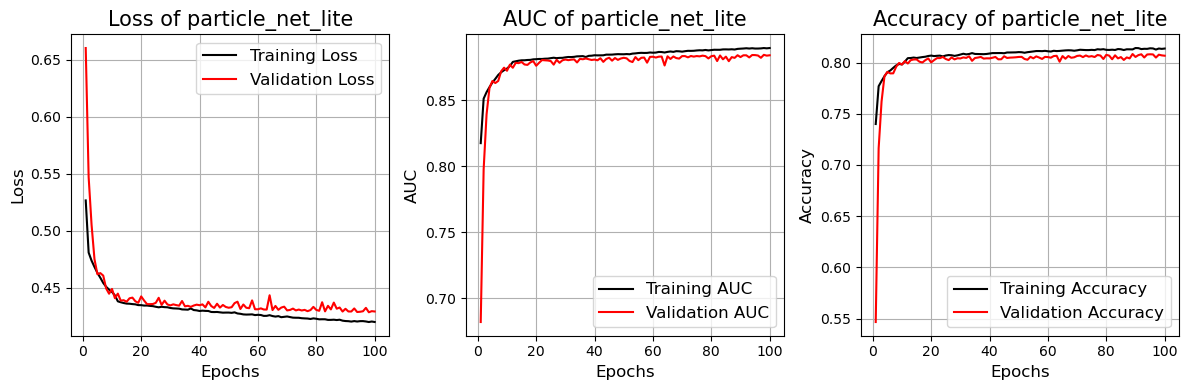

In [23]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['loss'], color= 'k', label='Training Loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_loss'], color='r', label='Validation Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['auc'], color= 'k', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_auc'], color='r', label='Validation AUC')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['accuracy'], color= 'k', label='Training Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# More commands
plt.tight_layout()
plt.show()

In [24]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(predictions): 
    """ 
    To plot the confusion matrix
    """
    cm = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(np.round(predictions), axis = 1))
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [str(i) for i in range(2)], 
                yticklabels = [str(i) for i in range(2)], fmt="d")
    fig = sns_hmp.get_figure()

In [25]:
# Predicting for the test examples
pred_class = model_lite.predict(test_dataset)

469/469 [==============================] - 8s 15ms/step


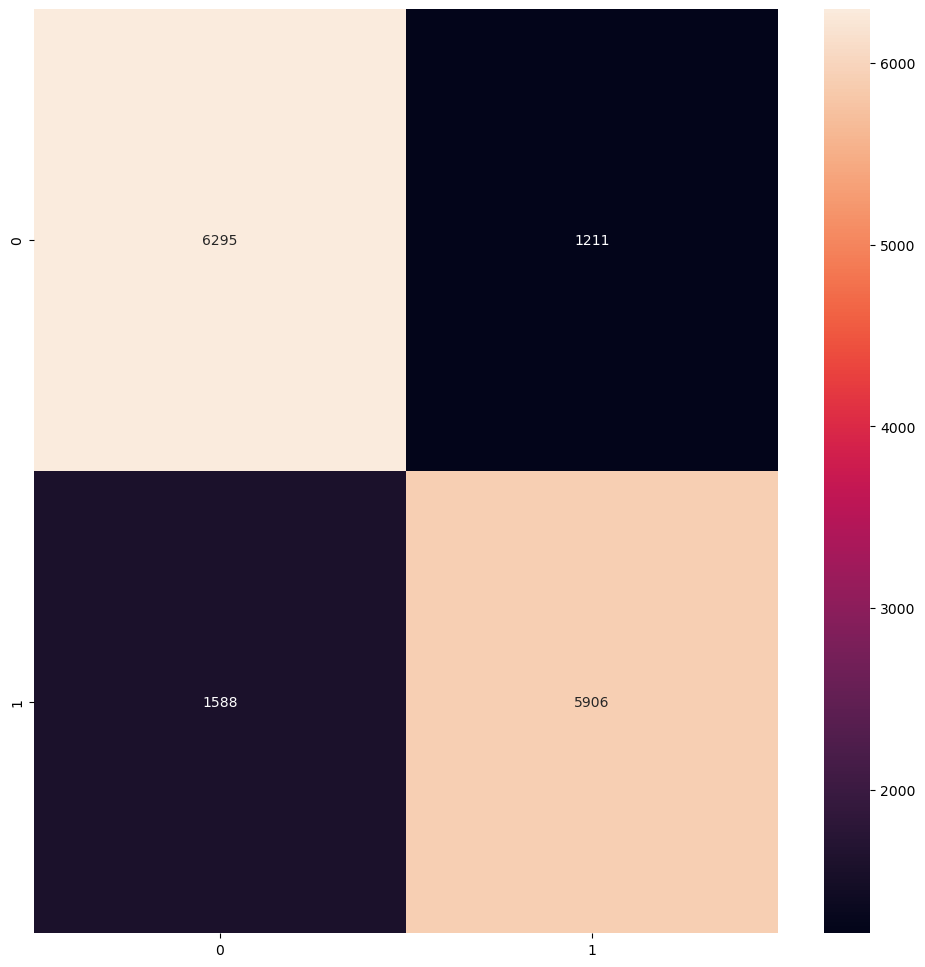

In [26]:
# Calling the function to plot the confusion matrix
conf_matrix(pred_class)

### Model-2
ParticleNetliteL1

In [27]:
# Calling Model-2 
model_lite_L1 = get_particle_net_lite_L1(classes, shapes)

In [28]:
batch_size = 1024
epochs = 100

def lr_schedule(epoch):
    lr = 1e-3

    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01

    return lr

In [29]:
# Initializing the loss, optimizer type and metrics
model_lite_L1.compile(loss='categorical_crossentropy',
              optimizer=tfk.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', tfk.metrics.AUC()])

In [30]:
# Seeing the model summary
model_lite_L1.summary()

Model: "ParticleNet_Lite_L1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 139, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 139, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 139, 1)       0           ['tf.cast_2[0][

In [31]:
# Setting the callbacks 
checkpoint_path_2 = "GNN_PNetlite_L1/cp.ckpt"
checkpoint_dir_2 = os.path.dirname(checkpoint_path_2)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2, verbose=0, save_weights_only=True)
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = tfk.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar, cp_callback]

In [32]:
# Train and track the history
history_L1 = model_lite_L1.fit(train_dataset, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(val_dataset, y_val),
                          shuffle=True,
                          callbacks=callbacks)

Epoch 1/100
69/69 [==============================] - 47s 687ms/sample - loss: 0.5203 - accuracy: 0.7451 - auc_1: 0.8227 - val_loss: 0.6179 - val_accuracy: 0.5913 - val_auc_1: 0.7061 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 41s 601ms/sample - loss: 0.4781 - accuracy: 0.7784 - auc_1: 0.8530 - val_loss: 0.5344 - val_accuracy: 0.7523 - val_auc_1: 0.8290 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 41s 600ms/sample - loss: 0.4737 - accuracy: 0.7811 - auc_1: 0.8560 - val_loss: 0.4960 - val_accuracy: 0.7777 - val_auc_1: 0.8535 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 37s 533ms/sample - loss: 0.4688 - accuracy: 0.7841 - auc_1: 0.8593 - val_loss: 0.4785 - val_accuracy: 0.7805 - val_auc_1: 0.8571 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 41s 601ms/sample - loss: 0.4663 - accuracy: 0.7848 - auc_1: 0.8610 - val_loss: 0.4704 - val_accuracy: 0.7831 - val_auc_1: 0.8590 - lr: 0.0010
Epoch 6/100
69/69 [======

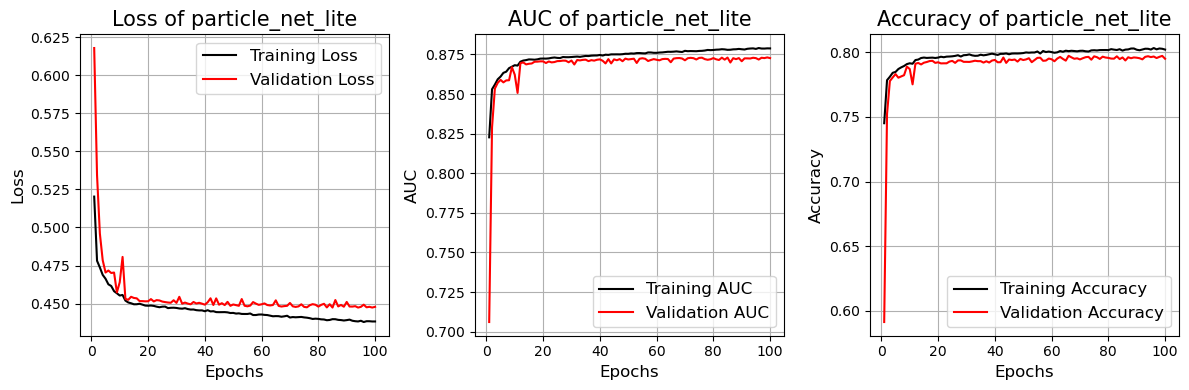

In [33]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['loss'], color= 'k', label='Training Loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_loss'], color='r', label='Validation Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['auc_1'], color= 'k', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_auc_1'], color='r', label='Validation AUC')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['accuracy'], color= 'k', label='Training Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy of particle_net_lite", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# More commands
plt.tight_layout()
plt.show()

In [34]:
# Predicting for the test examples
pred_class_L1 = model_lite_L1.predict(test_dataset)

469/469 [==============================] - 7s 15ms/step


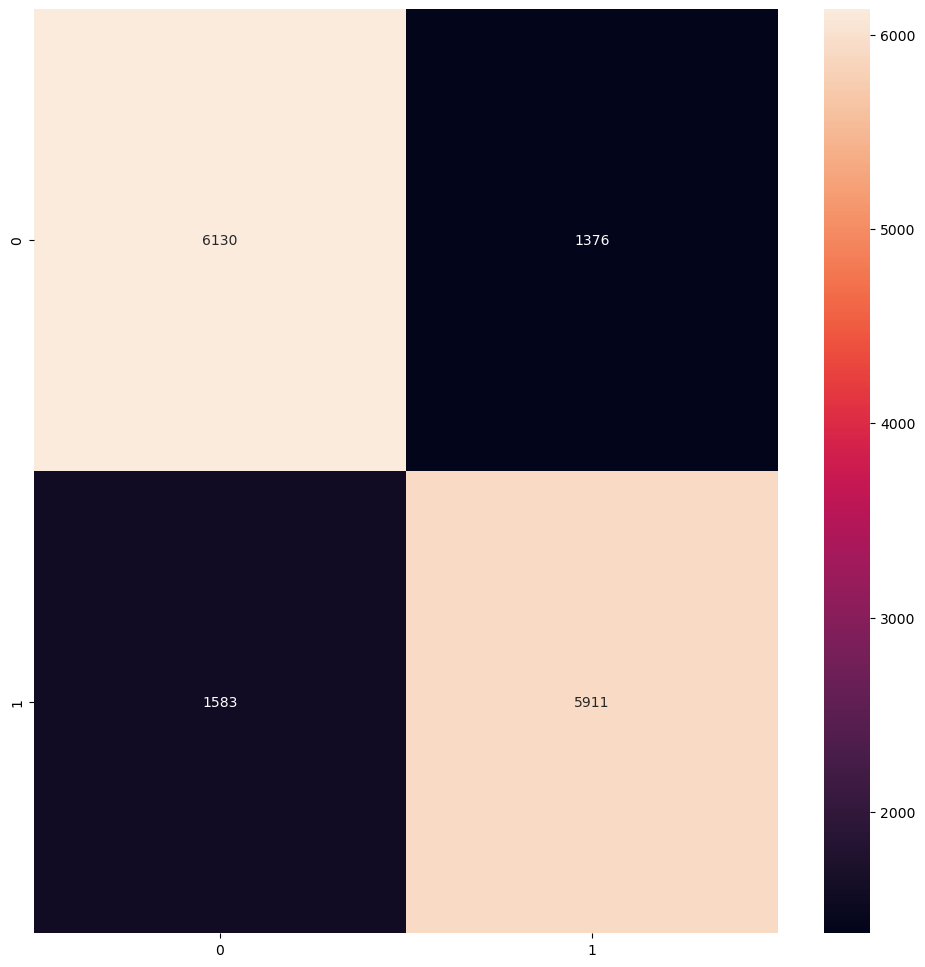

In [35]:
# Calling the function to plot the confusion matrix
conf_matrix(pred_class_L1)

### Comparing the Models:
We will compare the metrics over the Validation set.

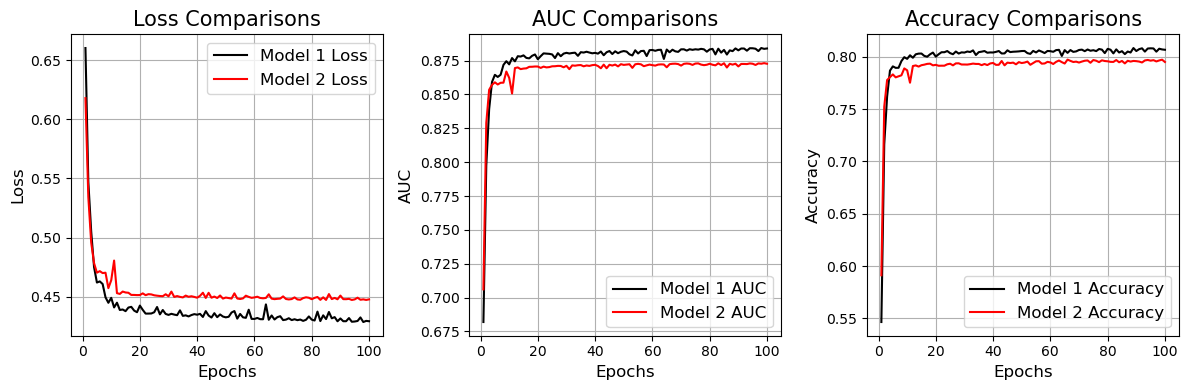

In [36]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_loss'], color= 'k', label='Model 1 Loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_loss'], color='r', label='Model 2 Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Comparisons", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_auc'], color= 'k', label='Model 1 AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_auc_1'], color='r', label='Model 2 AUC')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC Comparisons", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history.history['val_accuracy'], color= 'k', label='Model 1 Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_L1.history['val_accuracy'], color='r', label='Model 2 Accuracy')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Comparisons", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# More commands
plt.tight_layout()
plt.show()

Discussions on the above plots:



469/469 [==============================] - 8s 17ms/step - loss: 0.4262 - accuracy: 0.8134 - auc: 0.8858
Evaluation Metric of model_lite on Test Dataset
Loss: 0.42622110247612
Accuracy: 0.8133999705314636
AUC: 0.8858275413513184
469/469 [==============================] - 8s 16ms/step - loss: 0.4429 - accuracy: 0.8027 - auc_1: 0.8761
Evaluation Metric of model_lite_L1 on Test Dataset
Loss: 0.4428800344467163
Accuracy: 0.8027333617210388
AUC: 0.8760953545570374


(None, None)

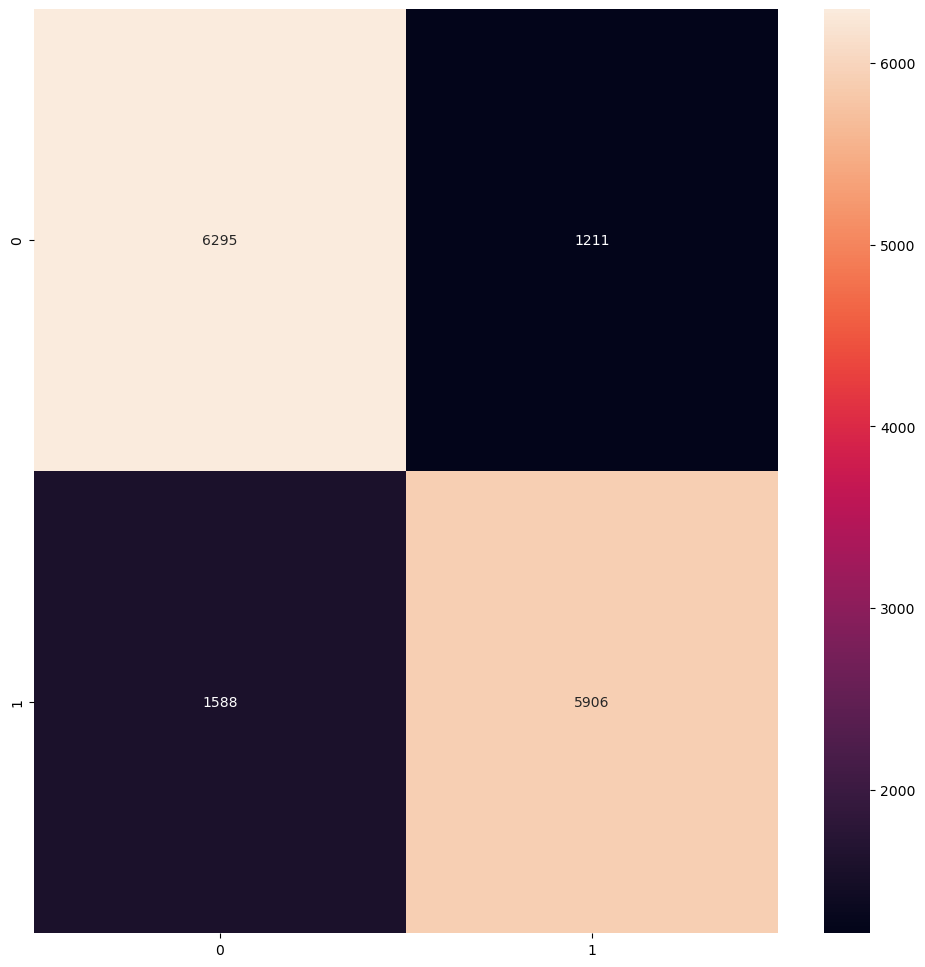

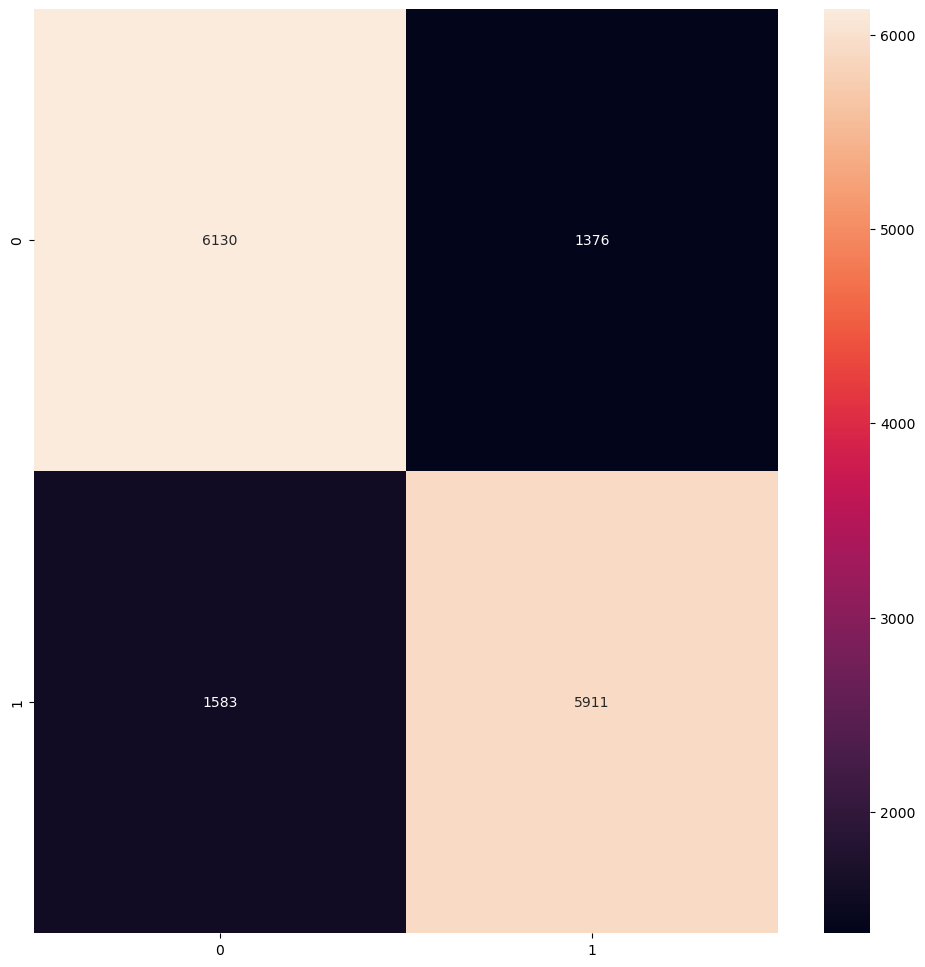

In [37]:
# Seeing the metrics and plotting the confusion matrix
loss, acc, auc = model_lite.evaluate(test_dataset, y_test)
print("Evaluation Metric of model_lite on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)

loss, acc, auc = model_lite_L1.evaluate(test_dataset, y_test)
print("Evaluation Metric of model_lite_L1 on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)
print("AUC:", auc)

conf_matrix(pred_class), conf_matrix(pred_class_L1)

# Conclusion:
We made use of two versions of a classical GNN architecture - ParticleNet and ParticleNetL1 using Tensorflow and Keras to classify Gluons and Quarks. It takes quite a lot of time to train these models and I therefore made use of GPU P100 available with Kaggle notebooks.

We observe that the training time is similar for both as the only difference is taking part in the KNN calculation method.

By looking at the above results:

- Model that made use of Absolute distance:
    - **Loss**: 0.4428800344467163
    - **Accuracy**:0.8027333617210388
    - **AUC**: 0.8760953545570374
    
- The orginal model that made use of squared distance:
    - **Loss**: 0.42622110247612
    - **Accuracy**: 0.8133999705314636
    - **AUC**: 0.8858275413513184

we may conclude that the original- squared distance metric is better than the other one and the authors of the paper did the right thing by choosing that as a metric. However it's always a good option to use L-1 norm for distance calculation when the number of features are way too much. In such cases I hypothesize that ParticleNet or any other graph neural network that makes use of KNNs for projections, should use L1 norm to calculate the distances as it may actually turn out to be better.

### References
1. [Paper](https://arxiv.org/abs/1902.08570)
2. [Data Sets](https://zenodo.org/record/3164691#.ZBv8C3ZBy5e)